In [171]:
!pip install gymnasium

In [172]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
#!pip install --upgrade ptan torch
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

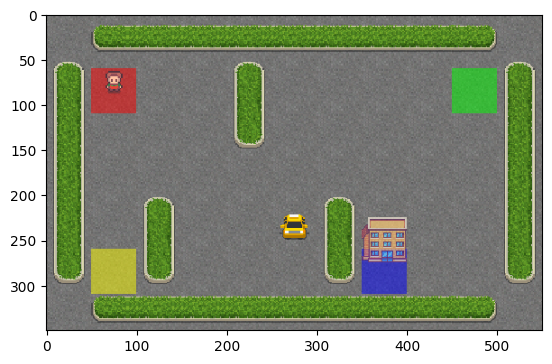

In [173]:
env=gym.make('Taxi-v3',render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [174]:
n_s=env.observation_space.n
n_a=env.action_space.n
n_epi=20
disc=.95
eps=1 #eps-=(1/n_epi)

In [175]:
def get_in(s_bat,n_s=n_s):
  s_oh=[]
  for s in s_bat:
    oh=np.zeros(n_s)
    oh[s]=1
    s_oh.append(oh)
  return torch.Tensor(s_oh)

In [176]:
def pi_eps(model,s,eps):
  u=random.random()
  if u>=eps:
    a=np.argmax(model(get_in([s])).data.numpy())
  else:
    a=env.action_space.sample()
  return a

In [177]:
def get_bat(replay,n_bat):
  bat=random.sample(replay,n_bat)
  s_bat=[s for (s,a,r,s1,d) in bat]
  a_bat=torch.Tensor([a for (s,a,r,s1,d) in bat]).long()
  r_bat=torch.Tensor([r for (s,a,r,s1,d) in bat])
  s1_bat=[s1 for (s,a,r,s1,d) in bat]
  done_bat=torch.Tensor([d for (s,a,r,s1,d) in bat])
  return s_bat,a_bat,r_bat,s1_bat,done_bat

In [178]:
n_buf=10000
n_bat=200

In [179]:
replay=deque(maxlen=n_buf)

In [180]:
h1=50

In [181]:
Q_main=torch.nn.Sequential(
    torch.nn.Linear(n_s,h1),
    torch.nn.ReLU(),
    torch.nn.Linear(h1,n_a),
)

In [182]:
sync_freq=2

In [183]:
Q_tar=copy.deepcopy(Q_main)
Q_tar.load_state_dict(Q_main.state_dict())

<All keys matched successfully>

In [184]:
losses=[]

In [185]:
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(Q_main.parameters(),lr=1e-3)

In [186]:
t=0
env=gym.make('Taxi-v3',render_mode=None)

In [187]:
for i in tqdm(range(n_epi)):
  s,_=env.reset()
  done=False
  while not done:
    a=pi_eps(Q_main,s,eps)
    s1,r,done,_,_=env.step(a)
    replay.append((s,a,r,s1,done))
    s=s1
    if len(replay)>n_bat:
      s_bat,a_bat,r_bat,s1_bat,done_bat=get_bat(replay,n_bat)
      q_pre=Q_main(get_in(s_bat))
      y_hat=q_pre.gather(dim=1,index=a_bat.unsqueeze(dim=1)).squeeze()
      with torch.no_grad():
        q_tar_s1=Q_tar(get_in(s1_bat))
        max_q_tar_s1=torch.max(q_tar_s1,dim=1).values
        y=r_bat+(1-done_bat)*(disc*max_q_tar_s1)
      loss=loss_fn(y.detach(),y_hat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      t+=1
    if t%sync_freq==0:
      Q_tar.load_state_dict(Q_main.state_dict())
  if eps>0.1:
    eps-=(1/n_epi)

100%|██████████| 20/20 [07:06<00:00, 21.34s/it]


Text(0, 0.5, 'Loss')

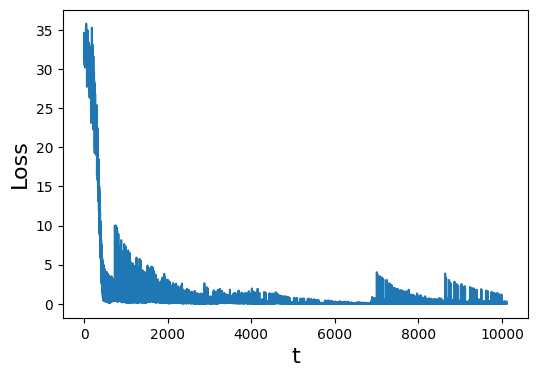

In [188]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

In [189]:
for s in range(n_s):
  print('s=',Q_main(get_in([s])).data.numpy())

s= [[ 2.202205   2.4534965  1.996089   2.2784317 -4.697157  -3.6538014]]
s= [[ 0.29746762  1.7545142   1.1524482   1.3107595   3.6481829  -5.8070254 ]]
s= [[ -9.9402895  -9.315841   -9.324821   -9.475147   -8.260841  -16.79024  ]]
s= [[ 4.3378286  5.7432528  4.336936   5.66185    7.1785808 -3.3953583]]
s= [[ -3.9617727  -4.850523   -4.055333   -4.814601  -13.818206  -13.89514  ]]
s= [[ 1.9916602  2.2461014  1.9953146  2.0488305 -4.9301133 -4.0453796]]
s= [[ -9.734224  -9.992763  -9.466805  -9.999592 -18.463772 -18.999655]]
s= [[ 0.52584237  0.04483563 -1.0747786  -0.90070844 -9.639612   -9.553034  ]]
s= [[ 2.095298   2.306404   1.9766679  2.3626995 -4.5958133 -3.8893895]]
s= [[ -0.41164407  -1.4846692   -2.3669567   -1.447439   -10.430292
  -10.474653  ]]
s= [[ 2.1284437  2.2176886  1.9292059  2.092315  -4.922983  -3.8573172]]
s= [[ 2.0469787   0.93767935 -0.11288503  0.95652795 -8.032805   -8.089595  ]]
s= [[ -6.3374023  -6.717083   -6.018255   -6.667078  -15.669918  -14.670744 ]]
s= 

In [190]:
pi_opt=np.zeros(n_s)
for s in range(n_s):
  if s not in [5,7,11,12,15]:
    pi_opt[s]=pi_eps(Q_main,s,eps=0)
pi_opt

array([1., 4., 4., 4., 0., 0., 2., 0., 3., 0., 1., 0., 0., 0., 1., 0., 5.,
       0., 1., 0., 3., 3., 3., 3., 0., 1., 1., 0., 1., 0., 3., 0., 1., 0.,
       1., 1., 3., 0., 0., 0., 3., 0., 0., 0., 1., 1., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 2., 1., 0., 0., 0., 2., 1., 1., 3.,
       1., 0., 1., 0., 0., 0., 1., 1., 0., 2., 1., 0., 1., 0., 0., 0., 4.,
       1., 0., 4., 1., 0., 3., 0., 0., 0., 1., 1., 3., 5., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 3., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       2., 1., 3., 1., 3., 0., 1., 0., 0., 1., 3., 1., 3., 0., 0., 1., 1.,
       3., 0., 0., 0., 1., 0., 2., 0., 2., 3., 2., 2., 1., 0., 1., 0., 2.,
       2., 1., 1., 0., 0., 3., 2., 1., 3., 0., 0., 2., 1., 1., 2., 1., 0.,
       1., 0., 0., 0., 1., 1., 3., 1., 3., 0., 0., 3., 3., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 3., 1., 3., 1., 1., 1., 1.,
       2., 1., 2., 2., 1., 0., 1., 0., 2., 2., 1., 1., 1., 2., 0., 2., 1.,
       1., 3., 1., 2., 1.

In [191]:
def test_agent(model,n_t=100,mode='human',display=True):
  env=gym.make('Taxi-v3',render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    a=pi_eps(model,s,eps=0)
    s1,r,done,_,_=env.step(a)
    if display:
      print('t=',t,'s=',s,'r=',r,'s\=',s1,'done=',done)
      clear_output(wait=True)
    s=s1
    if done:
      if display:
        if r==20:
          print('YOU WON! Reward: %s' % (r))
        else:
          print('YOU LOST.')
      break
  if not done:
    if display:
      print('LOST: too many moves.')
  win=True if r==20 else False
  return win

In [192]:
n_t=100
test_agent(Q_main,n_t)

LOST: too many moves.


False

In [193]:
n_game=1000
n_win=0
for i in range(n_game):
  win=test_agent(Q_main,mode=None,display=False)
  if win:
    n_win+=1
win_rate=n_win/n_game
print('Games play:{},# of wins:{}'.format(n_game,n_win))
print('Win Rate:{}%'.format(100*win_rate))

Games play:1000,# of wins:589
Win Rate:58.9%
